# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import isnan, count, when, col, desc, udf, sort_array, asc, avg
from pyspark.sql.types import IntegerType

In [2]:
# create a Spark session
spark = SparkSession \
    .builder \
    .appName("Sparkify_Project") \
    .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

## Loading and reading the basic information of dataset
To begin the total project, we want to load the dataset and check the columns or rows we have in the dataset

In [3]:
#Load Dataset
df = spark.read.json("mini_sparkify_event_data.json")

In [4]:
#Get basic information in dataset
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [5]:
# Total rows inside the dataset
df.count()

286500

In [6]:
# Statistics of the column
for items in df.schema.names:
    print (df.describe(items).show())

+-------+------------------+
|summary|            artist|
+-------+------------------+
|  count|            228108|
|   mean| 551.0852017937219|
| stddev|1217.7693079161374|
|    min|               !!!|
|    max| ÃÂlafur Arnalds|
+-------+------------------+

None
+-------+----------+
|summary|      auth|
+-------+----------+
|  count|    286500|
|   mean|      null|
| stddev|      null|
|    min| Cancelled|
|    max|Logged Out|
+-------+----------+

None
+-------+---------+
|summary|firstName|
+-------+---------+
|  count|   278154|
|   mean|     null|
| stddev|     null|
|    min| Adelaida|
|    max|   Zyonna|
+-------+---------+

None
+-------+------+
|summary|gender|
+-------+------+
|  count|278154|
|   mean|  null|
| stddev|  null|
|    min|     F|
|    max|     M|
+-------+------+

None
+-------+------------------+
|summary|     itemInSession|
+-------+------------------+
|  count|            286500|
|   mean|114.41421291448516|
| stddev|129.76726201140994|
|    min|          

In [7]:
# Writing the function to find missing value in each column
def finding_missing(df,col):
    return df.filter((isnan(df[col])) | (df[col].isNull()) | (df[col] == "")).count()

In [8]:
# Showing the missing value in each column
print("missing values\n")
for col in df.columns:
    missing_count = finding_missing(df, col)
    if missing_count > 0:
        print("{}: {}".format(col, missing_count))

missing values

artist: 58392
firstName: 8346
gender: 8346
lastName: 8346
length: 58392
location: 8346
registration: 8346
song: 58392
userAgent: 8346
userId: 8346


In [9]:
# filter for users with blank user id and session id
df = df.dropna(how = "any",subset =["userId","sessionId"])
df = df.filter(df['userID']!="")
# checking the total rows # after dropping the missing value
df.count()

278154

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [10]:
#Get basic information in dataset
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [11]:
category = []
interger = []

for item in df.schema:
    if str(item.dataType) == 'StringType':
        category.append(item.name)
    else:
        interger.append(item.name)

In [12]:
category

['artist',
 'auth',
 'firstName',
 'gender',
 'lastName',
 'level',
 'location',
 'method',
 'page',
 'song',
 'userAgent',
 'userId']

In [13]:
interger

['itemInSession', 'length', 'registration', 'sessionId', 'status', 'ts']

In [14]:
# statistic of interger columns
df.describe(interger).show()

+-------+------------------+-----------------+--------------------+------------------+------------------+--------------------+
|summary|     itemInSession|           length|        registration|         sessionId|            status|                  ts|
+-------+------------------+-----------------+--------------------+------------------+------------------+--------------------+
|  count|            278154|           228108|              278154|            278154|            278154|              278154|
|   mean|114.89918174824018|249.1171819778458|1.535358834084427...|1042.5616241362698|209.10321620397335|1.540958915431871...|
| stddev|  129.851729399489|99.23517921058361| 3.291321616327586E9| 726.5010362219813|30.151388851328214|1.5068287123306298E9|
|    min|                 0|          0.78322|       1521380675000|                 1|               200|       1538352117000|
|    max|              1321|       3024.66567|       1543247354000|              2474|               404|      

### UserID insight

In [15]:
# unique user in the dataset:
df.select('userId').dropDuplicates().count()

225

In [16]:
# the list of most interactive users:
df.select(['userId','page']).groupby('userId').count().dropna().orderBy('count',ascending = False).show()

+------+-----+
|userId|count|
+------+-----+
|    39| 9632|
|    92| 7230|
|   140| 6880|
|300011| 5732|
|   124| 4825|
|300021| 4659|
|300017| 4428|
|    85| 4370|
|    42| 4257|
|200023| 3769|
|     6| 3761|
|    29| 3603|
|    54| 3437|
|   100| 3214|
|     9| 3191|
|   126| 3102|
|300015| 3051|
|    91| 3014|
|    98| 2891|
|    74| 2887|
+------+-----+
only showing top 20 rows



### Artist insight

In [17]:
# Unique artist in the dataset
df.select('artist').dropDuplicates().count()

17656

In [18]:
# Artist with most interactions
df.select('artist').groupby('artist').count().dropna().orderBy('count',ascending = False).show()

+--------------------+-----+
|              artist|count|
+--------------------+-----+
|       Kings Of Leon| 1841|
|            Coldplay| 1813|
|Florence + The Ma...| 1236|
|       Dwight Yoakam| 1135|
|            BjÃÂ¶rk| 1133|
|      The Black Keys| 1125|
|                Muse| 1090|
|       Justin Bieber| 1044|
|        Jack Johnson| 1007|
|              Eminem|  953|
|           Radiohead|  884|
|     Alliance Ethnik|  876|
|               Train|  854|
|        Taylor Swift|  840|
|         OneRepublic|  828|
|         The Killers|  822|
|         Linkin Park|  787|
|         Evanescence|  781|
|            Harmonia|  729|
|       Guns N' Roses|  713|
+--------------------+-----+
only showing top 20 rows



## Songs insight

In [19]:
#Unique songs in the dataset
df.select('song').dropDuplicates().count()

58481

In [20]:
#Song with most interactions
df.select(['artist','song']).groupby('song').count().dropna().orderBy('count',ascending = False).show()

+--------------------+-----+
|                song|count|
+--------------------+-----+
|      You're The One| 1153|
|                Undo| 1026|
|             Revelry|  854|
|       Sehr kosmisch|  728|
|Horn Concerto No....|  641|
|Dog Days Are Over...|  574|
|             Secrets|  466|
|        Use Somebody|  459|
|              Canada|  435|
|             Invalid|  424|
|    Ain't Misbehavin|  409|
|       ReprÃÂ©sente|  393|
|SinceritÃÂ© Et J...|  384|
|Catch You Baby (S...|  373|
|              Yellow|  343|
|    Somebody To Love|  343|
|    Hey_ Soul Sister|  334|
|            The Gift|  327|
|           Fireflies|  312|
|          Love Story|  309|
+--------------------+-----+
only showing top 20 rows



### Page insight

In [21]:
# Unique page in the dataset
df.select('page').dropDuplicates().count()

19

In [22]:
# total visit for each page
df.select('page').groupby('page').count().dropna().orderBy('count',ascending = False).show(19)

+--------------------+------+
|                page| count|
+--------------------+------+
|            NextSong|228108|
|           Thumbs Up| 12551|
|                Home| 10082|
|     Add to Playlist|  6526|
|          Add Friend|  4277|
|         Roll Advert|  3933|
|              Logout|  3226|
|         Thumbs Down|  2546|
|           Downgrade|  2055|
|            Settings|  1514|
|                Help|  1454|
|             Upgrade|   499|
|               About|   495|
|       Save Settings|   310|
|               Error|   252|
|      Submit Upgrade|   159|
|    Submit Downgrade|    63|
|              Cancel|    52|
|Cancellation Conf...|    52|
+--------------------+------+



### Auth insight

In [23]:
# Total auth categories
df.select('auth').dropDuplicates().show()

+---------+
|     auth|
+---------+
|Cancelled|
|Logged In|
+---------+



In [24]:
# Create the sql table
df.createOrReplaceTempView("df_table")
# finding distinct user number who choose Cancelled
spark.sql("SELECT COUNT(DISTINCT userID) \
            FROM df_table\
            WHERE auth = 'Cancelled'").show()

+----------------------+
|count(DISTINCT userID)|
+----------------------+
|                    52|
+----------------------+



In [25]:
# distinct user number who choose Logged In
spark.sql("SELECT COUNT(DISTINCT userID) \
            FROM df_table\
            WHERE auth = 'Logged In'").show()

+----------------------+
|count(DISTINCT userID)|
+----------------------+
|                   225|
+----------------------+



### User insight

In [26]:
# distinct userID in the dataset
df.select('userID').dropDuplicates().show()

+------+
|userID|
+------+
|100010|
|200002|
|   125|
|    51|
|   124|
|     7|
|    54|
|    15|
|   155|
|   132|
|   154|
|100014|
|   101|
|    11|
|   138|
|300017|
|    29|
|    69|
|100021|
|    42|
+------+
only showing top 20 rows



In [27]:
# distinct user #
df.select('userID').dropDuplicates().count()

225

### Gender insight

In [28]:
df.select('gender').dropDuplicates().show()

+------+
|gender|
+------+
|     F|
|     M|
+------+



In [29]:
# user number in female
spark.sql("SELECT COUNT(DISTINCT userID) \
            FROM df_table\
            WHERE gender = 'F'").show()

+----------------------+
|count(DISTINCT userID)|
+----------------------+
|                   104|
+----------------------+



In [30]:
# user number in female
spark.sql("SELECT COUNT(DISTINCT userID) \
            FROM df_table\
            WHERE gender = 'M'").show()

+----------------------+
|count(DISTINCT userID)|
+----------------------+
|                   121|
+----------------------+



### level insight

In [31]:
#'level'
df.select('level').dropDuplicates().show()

+-----+
|level|
+-----+
| free|
| paid|
+-----+



In [32]:
# user number in different level
spark.sql("SELECT COUNT(DISTINCT userID) \
            FROM df_table\
            WHERE level = 'free'").show()

+----------------------+
|count(DISTINCT userID)|
+----------------------+
|                   195|
+----------------------+



In [33]:
spark.sql("SELECT COUNT(DISTINCT userID) \
            FROM df_table\
            WHERE level = 'paid'").show()

+----------------------+
|count(DISTINCT userID)|
+----------------------+
|                   165|
+----------------------+



### Method insight

In [34]:
#'method'
df.select('method').dropDuplicates().show()

+------+
|method|
+------+
|   PUT|
|   GET|
+------+



In [35]:
# user number in different method
spark.sql("SELECT COUNT(DISTINCT userID) \
            FROM df_table\
            WHERE method = 'PUT'").show()

+----------------------+
|count(DISTINCT userID)|
+----------------------+
|                   225|
+----------------------+



In [36]:
# user number in different method
spark.sql("SELECT COUNT(DISTINCT userID) \
            FROM df_table\
            WHERE method = 'GET'").show()

+----------------------+
|count(DISTINCT userID)|
+----------------------+
|                   224|
+----------------------+



### User Agent insight

In [37]:
df.select('userAgent').dropDuplicates().show()

+--------------------+
|           userAgent|
+--------------------+
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Win...|
|Mozilla/5.0 (X11;...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|Mozilla/5.0 (Maci...|
|Mozilla/5.0 (Wind...|
|Mozilla/5.0 (Wind...|
|Mozilla/5.0 (comp...|
|"Mozilla/5.0 (Win...|
|Mozilla/5.0 (Maci...|
|"Mozilla/5.0 (Win...|
|"Mozilla/5.0 (iPh...|
|"Mozilla/5.0 (Win...|
|Mozilla/5.0 (Wind...|
|Mozilla/5.0 (comp...|
|Mozilla/5.0 (comp...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Win...|
+--------------------+
only showing top 20 rows



In [38]:
# total number of different agents
df.select('userAgent').dropDuplicates().count()

56

### Location insight

In [39]:
df.select('location').dropDuplicates().show()

+--------------------+
|            location|
+--------------------+
|     Gainesville, FL|
|Atlantic City-Ham...|
|Deltona-Daytona B...|
|San Diego-Carlsba...|
|Cleveland-Elyria, OH|
|Kingsport-Bristol...|
|New Haven-Milford...|
|Birmingham-Hoover...|
|  Corpus Christi, TX|
|         Dubuque, IA|
|Las Vegas-Henders...|
|Indianapolis-Carm...|
|Seattle-Tacoma-Be...|
|          Albany, OR|
|   Winston-Salem, NC|
|     Bakersfield, CA|
|Los Angeles-Long ...|
|Minneapolis-St. P...|
|San Francisco-Oak...|
|Phoenix-Mesa-Scot...|
+--------------------+
only showing top 20 rows



In [40]:
# Number of locations in dataset
df.select('location').dropDuplicates().count()

114

In [41]:
### Time insight

### Define Churn
As it mentioned above, the churn event would be 'Cancellation Confirmation' in the page column.
And another option for churn would be downgrade event, which is 'Submit Downgrade' in the page column.

#### Cancellation Churn

In [42]:
# Finding the page with cancellation confirmation
df.filter("page = 'Cancellation Confirmation'").show()

+------+---------+---------+------+-------------+---------+------+-----+--------------------+------+--------------------+-------------+---------+----+------+-------------+--------------------+------+
|artist|     auth|firstName|gender|itemInSession| lastName|length|level|            location|method|                page| registration|sessionId|song|status|           ts|           userAgent|userId|
+------+---------+---------+------+-------------+---------+------+-----+--------------------+------+--------------------+-------------+---------+----+------+-------------+--------------------+------+
|  null|Cancelled|   Adriel|     M|          104|  Mendoza|  null| paid|  Kansas City, MO-KS|   GET|Cancellation Conf...|1535623466000|      514|null|   200|1538943990000|"Mozilla/5.0 (Mac...|    18|
|  null|Cancelled|    Diego|     M|           56|    Mckee|  null| paid|Phoenix-Mesa-Scot...|   GET|Cancellation Conf...|1537167593000|      540|null|   200|1539033046000|"Mozilla/5.0 (iPh...|    32|


In [43]:
# Adding a new column where define the churn event as 1 and 0
churn = udf(lambda x:1 if x == 'Cancellation Confirmation' else 0, IntegerType())
df = df.withColumn('Churn',churn(df.page))

In [44]:
# showing basic stas in the churn column
df.describe('Churn').show()

+-------+--------------------+
|summary|               Churn|
+-------+--------------------+
|  count|              278154|
|   mean|1.869467992550889E-4|
| stddev|0.013671595449116164|
|    min|                   0|
|    max|                   1|
+-------+--------------------+



In [45]:
# Create the table with Churn column
df.createOrReplaceTempView("df_table")

In [46]:
# finding the churn numbers in dataset

spark.sql("SELECT COUNT(DISTINCT userID)\
            FROM df_table\
            WHERE Churn = 1").show()

+----------------------+
|count(DISTINCT userID)|
+----------------------+
|                    52|
+----------------------+



In [47]:
#Calculate the churn rate
churn_rate = 52/225
print ('The churn rate in this dataset is {:%}'.format(churn_rate))

The churn rate in this dataset is 23.111111%


### Downgrade churn 

In [48]:
# Downgrade churn
Downgrade = udf(lambda x:1 if x == 'Submit Downgrade' else 0, IntegerType())
df = df.withColumn('Downgrade',Downgrade(df.page))

In [49]:
# stas of downgrade column
df.describe('Downgrade').show()

+-------+--------------------+
|summary|           Downgrade|
+-------+--------------------+
|  count|              278154|
|   mean|2.264932375590500...|
| stddev|0.015048014901098822|
|    min|                   0|
|    max|                   1|
+-------+--------------------+



In [50]:
# Create the table with Downgrade column
df.createOrReplaceTempView("df_table")

In [51]:
spark.sql("SELECT COUNT(DISTINCT userID) \
            FROM df_table\
            WHERE Downgrade = 1").show()

+----------------------+
|count(DISTINCT userID)|
+----------------------+
|                    49|
+----------------------+



In [52]:
#Calculate the downgrade rate
downgrade_rate = 49/225
print ('The downgrade rate in this dataset is {:%}'.format(downgrade_rate))

The downgrade rate in this dataset is 21.777778%


### The category effects regarding different features
Based on the previous category informations, the churn rate will be possible effected by the value in feature.
I want to take a look into how would these category feature values effect the churn action.

### Comparison of churn and downgrade in different categories

In [53]:
# import graph library
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [54]:
# Churn difference in gender
churn_gender_pd = df.select(['userID','gender','Downgrade','Churn']).dropDuplicates().toPandas()
churn_gender_pd.head()

,userID,gender,Downgrade,Churn
0,300015,M,0,0
1,106,F,0,0
2,51,M,0,0
3,200021,F,0,0
4,12,F,0,0


Text(0.5,1,'Count of Churn and non-churned by gender')

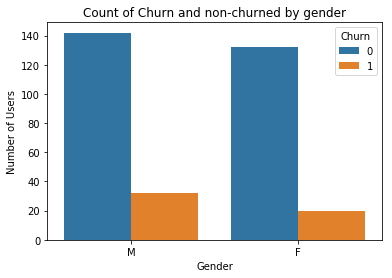

In [55]:
sns.countplot(x="gender", hue="Churn", data=churn_gender_pd)
plt.xlabel("Gender")
plt.ylabel("Number of Users")
plt.title("Count of Churn and non-churned by gender")

Text(0.5,1,'Count of Downgrade and non-Downgrade by gender')

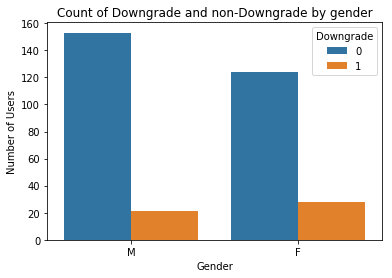

In [56]:
sns.countplot(x="gender", hue="Downgrade", data=churn_gender_pd)
plt.xlabel("Gender")
plt.ylabel("Number of Users")
plt.title("Count of Downgrade and non-Downgrade by gender")

In [57]:
# Churn difference in method
churn_method_pd = df.select(['userID','method','Churn','Downgrade']).dropDuplicates().toPandas()
churn_method_pd.head()

,userID,method,Churn,Downgrade
0,19,PUT,0,0
1,100009,PUT,0,0
2,300017,GET,0,0
3,120,GET,0,0
4,100004,PUT,0,0


Text(0.5,1,'Count of churned and non-churned by method')

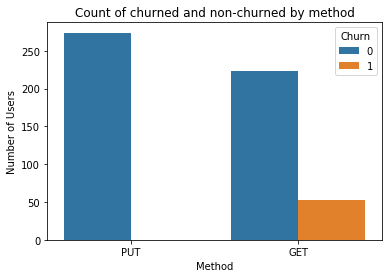

In [58]:
sns.countplot(x="method", hue="Churn", data=churn_method_pd)
plt.xlabel("Method")
plt.ylabel("Number of Users")
plt.title("Count of churned and non-churned by method")

Text(0.5,1,'Count of downgrade and non-downgrade by method')

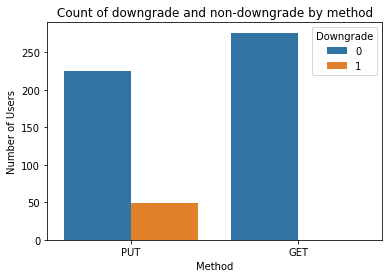

In [59]:
sns.countplot(x="method", hue="Downgrade", data=churn_method_pd)
plt.xlabel("Method")
plt.ylabel("Number of Users")
plt.title("Count of downgrade and non-downgrade by method")

In [60]:
# Churn difference in level
churn_level_pd = df.select(['userID','level','Churn','Downgrade']).dropDuplicates().toPandas()
churn_level_pd.head()

,userID,level,Churn,Downgrade
0,45,paid,0,0
1,53,paid,1,0
2,100009,free,1,0
3,132,paid,0,0
4,103,free,0,0


Text(0.5,1,'Count of churned and non-churned by level')

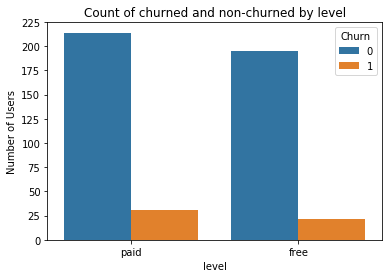

In [61]:
sns.countplot(x="level", hue="Churn", data=churn_level_pd)
plt.xlabel("level")
plt.ylabel("Number of Users")
plt.title("Count of churned and non-churned by level")

Text(0.5,1,'Count of downgrade and non-downgrade by level')

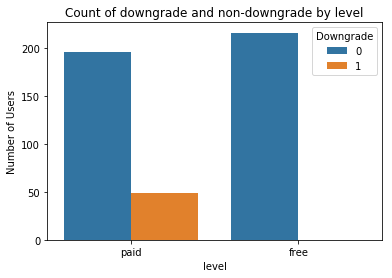

In [62]:
sns.countplot(x="level", hue="Downgrade", data=churn_level_pd)
plt.xlabel("level")
plt.ylabel("Number of Users")
plt.title("Count of downgrade and non-downgrade by level")

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

#### I am gonna trasfer following category features to dummy values:<br>
Gender: 1 for female, 0 for male<br>
level: 1 for paid, 0 for free<br>

#### Collect other useful feature:<br>
artist: total number of artist each user listen to<br>
length: total length of songs played by each users<br>
songs: total number of songs played by eahc users<br>
thumbs up: number of thumbs up<br>
thumbs down: number of thumbs down<br>
page: number of page visits for each user

#### The target column will be:<br>
Churn: 1 for churned, 0 for not churned<br>

In [63]:
# pick up the target column
df_target = df.groupby('userId').max("Churn").withColumnRenamed("max(Churn)", "target")

In [64]:
df_target.show(5)

+------+------+
|userId|target|
+------+------+
|100010|     0|
|200002|     0|
|   125|     1|
|    51|     1|
|   124|     0|
+------+------+
only showing top 5 rows



### 1. Gender

In [65]:
# transfer gender column
transform_gender = udf(lambda x: 1 if x == 'F' else 0, IntegerType())
df= df.withColumn("gender", transform_gender("gender"))
df.select('gender').show(5)

+------+
|gender|
+------+
|     0|
|     0|
|     0|
|     0|
|     0|
+------+
only showing top 5 rows



In [66]:
# collect gender for each user
user_gender = df.groupby('userId').agg({"gender": "max"}).withColumnRenamed("max(gender)", "gender")
user_gender.show(5)

+------+------+
|userId|gender|
+------+------+
|100010|     1|
|200002|     0|
|   125|     0|
|    51|     0|
|   124|     1|
+------+------+
only showing top 5 rows



In [67]:
user_gender.select('gender').dropDuplicates().show()

+------+
|gender|
+------+
|     1|
|     0|
+------+



In [68]:
# merge dataframe with total dataframe
df_total = df_target.join(user_gender, ['userId'])
df_total.show(5)

+------+------+------+
|userId|target|gender|
+------+------+------+
|100010|     0|     1|
|200002|     0|     0|
|   125|     1|     0|
|   124|     0|     1|
|    51|     1|     0|
+------+------+------+
only showing top 5 rows



### 2.Level

In [69]:
# transfer level column
transform_level = udf(lambda x: 1 if x == 'paid' else 0, IntegerType())
df= df.withColumn("level", transform_level("level"))
df.select('level').show(5)

+-----+
|level|
+-----+
|    1|
|    0|
|    1|
|    0|
|    1|
+-----+
only showing top 5 rows



In [70]:
# collect gender for each user
user_level = df.groupby('userId').agg({"level": "max"}).withColumnRenamed("max(level)", "level")
user_level.show(5)

+------+-----+
|userId|level|
+------+-----+
|100010|    0|
|200002|    1|
|   125|    0|
|    51|    1|
|   124|    1|
+------+-----+
only showing top 5 rows



In [71]:
user_level.select('level').dropDuplicates().show()

+-----+
|level|
+-----+
|    1|
|    0|
+-----+



In [72]:
# merge dataframe 
df_total = df_total.join(user_level, ['userId'])
df_total.show(5)

+------+------+------+-----+
|userId|target|gender|level|
+------+------+------+-----+
|100010|     0|     1|    0|
|200002|     0|     0|    1|
|   125|     1|     0|    0|
|   124|     0|     1|    1|
|    51|     1|     0|    1|
+------+------+------+-----+
only showing top 5 rows



### 3.Artist

In [73]:
user_artist = df.groupby("userId").agg({"artist": "count"}).withColumnRenamed("count(artist)", "artist_count")
user_artist.show(5)

+------+------------+
|userId|artist_count|
+------+------------+
|100010|         275|
|200002|         387|
|   125|           8|
|    51|        2111|
|   124|        4079|
+------+------------+
only showing top 5 rows



In [74]:
# merge dataframe with total dataframe
df_total = df_total.join(user_artist, ['userId'])
df_total.show(5)

+------+------+------+-----+------------+
|userId|target|gender|level|artist_count|
+------+------+------+-----+------------+
|100010|     0|     1|    0|         275|
|200002|     0|     0|    1|         387|
|   125|     1|     0|    0|           8|
|   124|     0|     1|    1|        4079|
|    51|     1|     0|    1|        2111|
+------+------+------+-----+------------+
only showing top 5 rows



### 4. Songs

In [75]:
user_song = df.groupby("userId").agg({"song": "count"}).withColumnRenamed("count(song)", "song_count")
user_song.show(5)

+------+----------+
|userId|song_count|
+------+----------+
|100010|       275|
|200002|       387|
|   125|         8|
|    51|      2111|
|   124|      4079|
+------+----------+
only showing top 5 rows



In [76]:
# merge dataframe with total dataframe
df_total = df_total.join(user_song, ['userId'])
df_total.show(5)

+------+------+------+-----+------------+----------+
|userId|target|gender|level|artist_count|song_count|
+------+------+------+-----+------------+----------+
|100010|     0|     1|    0|         275|       275|
|200002|     0|     0|    1|         387|       387|
|   125|     1|     0|    0|           8|         8|
|   124|     0|     1|    1|        4079|      4079|
|    51|     1|     0|    1|        2111|      2111|
+------+------+------+-----+------------+----------+
only showing top 5 rows



### 5. Length

In [77]:
user_length = df.groupby("userId").agg({"length": "sum"}).withColumnRenamed("sum(length)", "length")
user_length.show(5)

+------+------------------+
|userId|            length|
+------+------------------+
|100010| 66940.89735000003|
|200002| 94008.87593999993|
|   125|2089.1131000000005|
|    51| 523275.8428000004|
|   124|1012312.0927899999|
+------+------------------+
only showing top 5 rows



In [78]:
# merge dataframe with total dataframe
df_total = df_total.join(user_length, ['userId'])
df_total.show(5)

+------+------+------+-----+------------+----------+------------------+
|userId|target|gender|level|artist_count|song_count|            length|
+------+------+------+-----+------------+----------+------------------+
|100010|     0|     1|    0|         275|       275| 66940.89735000003|
|200002|     0|     0|    1|         387|       387| 94008.87593999993|
|   125|     1|     0|    0|           8|         8|2089.1131000000005|
|   124|     0|     1|    1|        4079|      4079|1012312.0927899999|
|    51|     1|     0|    1|        2111|      2111| 523275.8428000004|
+------+------+------+-----+------------+----------+------------------+
only showing top 5 rows



### 6.Thumbs up

In [79]:
user_thumbs_up = df.filter(df["page"] == 'Thumbs Up').groupby('userId').count().withColumnRenamed("count", "thumb_up")
user_thumbs_up.show(5)

+------+--------+
|userId|thumb_up|
+------+--------+
|100010|      17|
|200002|      21|
|    51|     100|
|   124|     171|
|     7|       7|
+------+--------+
only showing top 5 rows



In [80]:
# merge dataframe with total dataframe
df_total = df_total.join(user_thumbs_up, ['userId'])
df_total.show(5)

+------+------+------+-----+------------+----------+------------------+--------+
|userId|target|gender|level|artist_count|song_count|            length|thumb_up|
+------+------+------+-----+------------+----------+------------------+--------+
|100010|     0|     1|    0|         275|       275| 66940.89735000003|      17|
|200002|     0|     0|    1|         387|       387| 94008.87593999993|      21|
|   124|     0|     1|    1|        4079|      4079|1012312.0927899999|     171|
|    51|     1|     0|    1|        2111|      2111| 523275.8428000004|     100|
|     7|     0|     0|    0|         150|       150| 38034.08710000002|       7|
+------+------+------+-----+------------+----------+------------------+--------+
only showing top 5 rows



### 7.Thumbs Down

In [81]:
user_thumbs_down = df.filter(df["page"] == 'Thumbs Down').groupby('userId').count().withColumnRenamed("count", "thumb_down")
user_thumbs_down.show(5)

+------+----------+
|userId|thumb_down|
+------+----------+
|100010|         5|
|200002|         6|
|    51|        21|
|   124|        41|
|     7|         1|
+------+----------+
only showing top 5 rows



In [82]:
# merge dataframe with total dataframe
df_total = df_total.join(user_thumbs_down, ['userId'])
df_total.show(5)

+------+------+------+-----+------------+----------+------------------+--------+----------+
|userId|target|gender|level|artist_count|song_count|            length|thumb_up|thumb_down|
+------+------+------+-----+------------+----------+------------------+--------+----------+
|100010|     0|     1|    0|         275|       275| 66940.89735000003|      17|         5|
|200002|     0|     0|    1|         387|       387| 94008.87593999993|      21|         6|
|   124|     0|     1|    1|        4079|      4079|1012312.0927899999|     171|        41|
|    51|     1|     0|    1|        2111|      2111| 523275.8428000004|     100|        21|
|     7|     0|     0|    0|         150|       150| 38034.08710000002|       7|         1|
+------+------+------+-----+------------+----------+------------------+--------+----------+
only showing top 5 rows



### 8. Page visit total

In [83]:
user_page = df.groupby("userId").agg({"page": "count"}).withColumnRenamed("count(page)", "page_count")
user_page.show(5)

+------+----------+
|userId|page_count|
+------+----------+
|100010|       381|
|200002|       474|
|   125|        11|
|    51|      2464|
|   124|      4825|
+------+----------+
only showing top 5 rows



In [84]:
# merge dataframe with total dataframe
df_total = df_total.join(user_page, ['userId'])
df_total.show(5)

+------+------+------+-----+------------+----------+------------------+--------+----------+----------+
|userId|target|gender|level|artist_count|song_count|            length|thumb_up|thumb_down|page_count|
+------+------+------+-----+------------+----------+------------------+--------+----------+----------+
|100010|     0|     1|    0|         275|       275| 66940.89735000003|      17|         5|       381|
|200002|     0|     0|    1|         387|       387| 94008.87593999993|      21|         6|       474|
|   124|     0|     1|    1|        4079|      4079|1012312.0927899999|     171|        41|      4825|
|    51|     1|     0|    1|        2111|      2111| 523275.8428000004|     100|        21|      2464|
|     7|     0|     0|    0|         150|       150| 38034.08710000002|       7|         1|       201|
+------+------+------+-----+------------+----------+------------------+--------+----------+----------+
only showing top 5 rows



# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [155]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression,RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import MinMaxScaler,VectorAssembler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

import re

In [86]:
df_model = df_total.drop("userID")

In [87]:
df_features = df_model.drop('target')
features = df_features.columns

### Train Test Split

In [88]:
rest, validation = df_model.randomSplit([0.9, 0.1], seed=42)

### Building Pipeline

In [158]:
def ml_model(model):
    assembler = VectorAssembler(inputCols=features, outputCol="NumFeatures")
    scaler = MinMaxScaler(inputCol="NumFeatures", outputCol="ScaledNumFeatures2")
    pipeline = Pipeline(stages=[assembler, scaler, model])
    
    paramGrid = ParamGridBuilder().build()
    
    crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(labelCol='target', metricName='f1'),
                          numFolds=3)
    return crossval

In [159]:
# logistic Regression
lr = LogisticRegression(featuresCol="ScaledNumFeatures2", labelCol="target")
model = ml_model(lr)
result = model.fit(rest)

In [160]:
# Random Forest Classifier
rf = RandomForestClassifier(featuresCol="ScaledNumFeatures2", labelCol="target")
rf_model = ml_model(rf)
result_2 = rf_model.fit(rest)

In [161]:
# GBT
gbt =GBTClassifier(featuresCol="ScaledNumFeatures2", labelCol="target")
gbt_model = ml_model(gbt)
result_3 = gbt_model.fit(rest)

### finding the accuracy of the ml model

In [162]:
def accuracy(results):
    model_result = results.transform(validation)
    right_pred = model_result.filter(model_result.target == model_result.prediction).count()
    total = model_result.count()
    accuracy = right_pred/total*100
    
    return ("The accracy of the model is : {}%".format(accuracy))

In [163]:
# calculate the accuracy for different models
#logistic regression
accuracy(result)

'The accracy of the model is : 60.0%'

In [165]:
#Random Forest Classifier
accuracy(result_2)

'The accracy of the model is : 66.66666666666666%'

In [167]:
#GBT
accuracy(result_3)

'The accracy of the model is : 66.66666666666666%'

## Conclusion

In this notebook, the dataset with the information of user using the Sparkify is being analyzed to predict whethere the user will continue their subscription with music playing application.<br>
The whole project is conducted under the pyspark language. The data is cleaned and scaled for EDA and churn prediction. The churn action in this dataset is defined as the cancellation confirmation of the subscribtion,which is aroung 23% and the service downgrade in the payment, around 21%. In the meanwhile, the gender, level and method have slightly impact on the churn action.<br>
In the modeling section, according to above modeling comparison, the random forest and gbt algorithm shows better accurancy than logisstic regression. The accuracy of these model are all around 60%.<br>